# Introduction

Neural networks are a great mathematical tool for classification problems (available also for regression *i. e.* for getting a number/set of numbers as a function of some inputs). They are very hyped at the moment, because they can create very complex non-linear functions that are able to do incredible things like distinguishing cats and dogs using the colors of the pixels of a digital photograph.

Their drawback is that they have a LOT of internal parameters, that means that you need thousands (if not millions) of input data to build a realistic model.

If you are not so familiarized with neural networks, read this great introduction from Matthew Stewart: https://towardsdatascience.com/simple-introduction-to-neural-networks-ac1d7c3d7a2c

Actually, I advise you to read all the articles by [him](https://towardsdatascience.com/@matthew_stewart) in Towards Data Science.

For images, there is a particular type of neural network that is very suitable: the convolutional neural network (CNN). Again, Matthew Stewart has a great [introduction about them](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac).

We will use all of this to try to predict the labels (a car, a cat, a frog...) of a list of images from the [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10).


# Preparation

OK, let's prepare our Notebook for doing some neural network stuff. First, let's include the standard header of all Kaggle notebooks.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Let's start importing some useful libraries

In [ ]:
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

And the TensorFlow and Keras libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Now we have to unzip the images that we will use to train the neural network (inspired by https://www.kaggle.com/faizanurrahmann/cifar-10-object-classification-cnn-keras)

In [ ]:
!pip install py7zr

from py7zr import unpack_7zarchive
import shutil
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('/kaggle/input/cifar-10/train.7z', '/kaggle/working')


# Reading training data

We finally have all the necessary libraries loaded and the training images in our working directory! We can start doing some neural network stuff.

But first we have to get the images in a format that a neural network can handle. How can we do that? With the PIL library that we have already loaded.

Images in a computer are nothing but an $a \times b$ matrix of pixels. Each pixel in the position $(x_a,y_b)$ has three values from 0 to 255 that specify what amount of [red, green and blue](https://simple.wikipedia.org/wiki/Primary_color) each pixel has. With that information, an image can reproduce up to 255$^\text{3}$ = 16 million colors.

Let's extract this color information and transform it into some mathematical structure that the neural network can handle: a numpy array! As previously mentioned, the PIL library is the way to go.

At the end we will get an array of the form $(n_{images},a,b,3)$ (3 because we have three color channels: red (R), green (G) and blue (B)).

In [ ]:
train_path = '/kaggle/working/train/'

train_list = listdir(train_path)

X_list = [0] * len(train_list)

for i_image in train_list:
    num_image = int(i_image[:-4]) -1
    imagen = Image.open(train_path + i_image)
    imagen_numpy = np.uint8(imagen)
    X_list[num_image] = imagen_numpy

X = np.array(X_list)

print(X.shape)

OK, now we have the "independent variables" X; but we need y, *i. e*. what are the labels associated to each image. For that we will read the trainLabels.csv file. This file contains the labels as text, and this is not what we want. We want a vector whose size is equal to the number of different labels (10 in CIFAR-10): each element of the array correspond to a label, and it will be 1 if this is the actual label of the image and zero otherwise. For example: "car" = (1,0,0,...,0,0), "bird" = (0,1,0,...,0,0). Sklearn has a tool for doing exactly that: [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
train_data = pd.read_csv('/kaggle/input/cifar-10/trainLabels.csv')
onehot_encoder = OneHotEncoder()
y = onehot_encoder.fit_transform(train_data[['label']])
y = y.toarray()

Now we want to check if all labels are more or less equally probable. Why is this important? Because we can have a *class imbalance*, and that can distort our model. For example, imagine that we have a set of dogs and cats, and 90 % of the images are dogs. A neural network that consider that *every* picture is a dog will still have a 90 % of accuracy.

In [ ]:
labels_df = train_data.groupby(['label']).count()
labels_matrix = y.sum(axis=0)
print(labels_df)
print(labels_matrix)

Fortunately it is not our case, all our classes are balanced. Good! If not, don't worry, there are ways to deal with that.

Finally, let's divide our labeled photographs in train and test sets. We won't use all the photographs for training, but instead only 60 % of it. The remaining will be used to test how the model performs in data that has not been used for training. We don't want a neural network that fits very good our training data, but it works horrible when we ask it to predict a photo that it hasn't seen before, i. e. we don't want [overfitting](https://en.wikipedia.org/wiki/Overfitting). For that, we will use the train set as a simple way of [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29 )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)

# Creation of a neural network

## Quick and dirty neural network

OK, I guess at this point you are kind of bored. When do we do some cool stuff? OK, I won't bore you anymore. Let's start now! The following code is quick and dirty, but it is very simple to understand.

In [ ]:
X_train_normalized = X_train/255.0
X_train_normalized = X_train_normalized.astype('float32')

neural_network = keras.Sequential([
    keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

neural_network.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

neural_network.fit(X_train_normalized,y_train, epochs=50)

nn_loss, nn_score = neural_network.evaluate(X_test,y_test,verbose=2)

print("The accuracy of the neural network on the test data is {0:4.3f}".format(nn_score,))

What have we done? The very first thing is to normalize the input: we want the data of the numpy array going from 0 to 1, instead of from 0 to 255, because neural networks work better with data between 0 and 1. The second line is more technical: we want to optimize the storage of the numpy array using single precision 32-bit float (`float32`) instead of the default `float64`, so the array size in memory is 50 % less.

Then we started a neural network with `keras.Sequential()`, that has a [CNN](https://keras.io/layers/convolutional/#conv2d) with 64 $3 \times 3$ matrix filters (see [this](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac#e051) to understand what matrix filters are), then we [flatten](https://keras.io/layers/core/#flatten) it to have a "classical" one-dimensional neural network structure, and finally two layers of neurons (one with 64 and one with 32) and a last one, that will be the output layer, *i. e.* it will tell us how likely is that the image is a horse or a dog, or something else. Following the example in the previous section, an output like (0.8,0.2,0,...,0,0) means that the image has a 80 % probability of being a car and 20 % of being a bird.


Now let's build something more sophisticated and generalizable. We will crate a function that generate a deeper neural network, whose architecture will depend on the input parameters.

## Systematic search for the best neural network

In [ ]:
def create_neural_network(train_array_iterator,test_array_iterator,num_filters_input,num_neurons_input,num_conv_input,num_maxpool_input,overfitting,label=None,verbosity=0):

    # Cleanup inputs

    num_filters = round(num_filters_input)
    num_neurons = round(num_neurons_input)
    num_conv = round(num_conv_input)
    num_maxpool = round(num_maxpool_input)
    if overfitting == 'l1':
        regularizer = l1(0.01)
    elif overfitting == 'l2':
        regularizer = l2(0.01)
    else:
        regularizer = None

    # Build the neural network

    neural_network = Sequential()
    neural_network.add(Conv2D(num_filters,(3,3),activation='relu',input_shape=(32,32,3)))
    for i_maxpool in range(num_maxpool):
        try:
            for i_conv in range(num_conv):
                neural_network.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same',
                                          kernel_regularizer=regularizer, bias_regularizer=regularizer))
            neural_network.add(MaxPooling2D(pool_size=(2,2)))
            if overfitting == 'Dropout':
                neural_network.add(Dropout(0.25))
            elif overfitting == 'Batch_Normalization':
                neural_network.add(BatchNormalization(momentum=0.99))
        except:
            break

    neural_network.add(keras.layers.Flatten())
    neural_network.add(keras.layers.Dense(num_neurons,activation='relu'))
    neural_network.add(keras.layers.Dense(round(num_neurons/2),activation='relu'))
    neural_network.add(keras.layers.Dense(10,activation='softmax'))
    neural_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Created a neural network with the following structure:')
    print(neural_network.summary())
    
    # Callbacks

    rlr = keras.callbacks.ReduceLROnPlateau(patience=15, verbose=1)
    es = keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
    print('Fitting the neural network')
    historia = neural_network.fit_generator(train_array_iterator, validation_data=test_array_iterator, epochs=50, verbose=verbosity, callbacks=[rlr,es])
    
    # Plot
    
    #plt.figure(figsize=[15,15])
    plt.figure()
    if label is None:
        plt.plot(historia.history['accuracy'], label='Train accuracy')
        plt.plot(historia.history['val_accuracy'], label='Test accuracy')
    else:
        plt.plot(historia.history['accuracy'], label='Train accuracy ({0})'.format(label))
        plt.plot(historia.history['val_accuracy'], label='Test accuracy ({0})'.format(label))
    plt.legend()
    
    return neural_network


This is something definitely more complex than our previous neural network, so let me explain it what this function does in more detail.

1) Cleanup inputs. Essentially it makes sure that num_filters and num_neurons are integer numbers, and are passed as such to Conv2D and Dense layers. It also creates a [regularizer object](https://keras.io/regularizers/) that may be l1 or l2. Regularizers prevent overfitting (see below); l1 and l2 do that by penalizing [large weights](https://www.machinecurve.com/index.php/2020/01/21/what-are-l1-l2-and-elastic-net-regularization-in-neural-networks/). See more details here for [l1](https://scikit-learn.org/stable/modules/linear_model.html#lasso) and here for [l2](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification). If you are a Bayesian fan, as myself, a very intuitive and more mathematically complex way of introducing l2 regularization is explained in this [article](https://katbailey.github.io/post/from-both-sides-now-the-math-of-linear-regression/).

2) Build the neural network. This essentially consist on a loop that create several multilayers consisting 2 CNN plus a [maxpooling](https://keras.io/layers/pooling/#maxpooling2d) for decreasing the complexity. If we are trying to prevent overfitting using [dropout](https://keras.io/layers/core/#dropout) or [batch normalization](https://keras.io/layers/normalization/#batchnormalization), we include the layers here. We finish it with a flatten layer to return to a 1D neural network, plus two layers, plus the output layer.

3) Finally we add a couple of [callbacks](https://keras.io/callbacks/). The callbacks change the convergence process on the fly, either by [reducing the learning rate](https://keras.io/callbacks/#reducelronplateau) or by [stopping](https://keras.io/callbacks/#earlystopping) it when the accuracy is not increasing anymore (even decreasing).

Then we fit the neural network with batches (see below) and we get a graph of how accuracy improves (for our training and our testing set) as a function of time.

We are going to train our neural network with batches. That means that instead of loading all the 30000 images in memory and use all of them at the same time each epoch, we will load a batch of photos in memory, train the neural network for this batch of photos, load a new batch of photos and train it for this new batch, and so on, until all of the photos are used for training. This has advantages and disadvantages. A great advantage is that we don't need to keep in memory all our photos (imagine if we are training 2 million of 800x600 photos, these are several TB, and no computer will be able to handle so much RAM memory. A disadvantage is that we lose some of the performance of GPUs because communication between GPU and CPU. Another thing is that we may get quite different results if we train on batches ([and this is sometimes good](https://towardsdatascience.com/simple-introduction-to-neural-networks-ac1d7c3d7a2c#7b42)).

Moreover, we can do more things while we create our batches. In this case we are normalizing the inputs (i. e. making sure that our inputs go from 0 to 1).

In [ ]:
train_preprocessor = ImageDataGenerator(rescale=1.0/255.0)
test_preprocessor = ImageDataGenerator(rescale=1.0/255.0)

train_iterator = train_preprocessor.flow(X_train,y_train,batch_size=256)
test_iterator = test_preprocessor.flow(X_test,y_test,batch_size=256)

red_neuronal = create_neural_network(train_iterator,test_iterator,64,32,2,2,None)


Great! Another neural network trained. See that in this case, the accuracy for the test set is close to 70 %, instead of 30 % for the quick an dirty one. But we can definitely improve the accuracy.

A way of doing that is using regularization. It is advised to do so in order to prevent two typical problems of neural networks: [overfitting](https://www.analyticsvidhya.com/blog/2018/11/neural-networks-hyperparameter-tuning-regularization-deeplearning/) and [exploding gradients](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/).

There are several ways of doing normalization. We are going to use l1, l2, dropout and batch normalization.

In [ ]:
train_preprocessor = ImageDataGenerator(rescale=1.0/255.0)
test_preprocessor = ImageDataGenerator(rescale=1.0/255.0)

train_iterator = train_preprocessor.flow(X_train,y_train,batch_size=256)
test_iterator = test_preprocessor.flow(X_test,y_test,batch_size=256)

normalization = {}

for i_normalizer in [None,'l1','l2','Dropout','Batch_normalization']:
#    train_preprocessor = ImageDataGenerator(rescale=1.0 / 255.0)
#    test_preprocessor = ImageDataGenerator(rescale=1.0 / 255.0)
#    train_iterator = train_preprocessor.flow(X_train, y_train, batch_size=256)
#    test_iterator = test_preprocessor.flow(X_test, y_test, batch_size=256)

    this_neural_network = create_neural_network(train_iterator,test_iterator,64,32,2,2,i_normalizer,i_normalizer)

#    test_preprocessor = ImageDataGenerator(rescale=1.0 / 255.0)
#    test_iterator = test_preprocessor.flow(X_test, y_test, batch_size=256)
    nn_loss, nn_score = this_neural_network.evaluate_generator(test_iterator,verbose=2)
    normalization[i_normalizer] = nn_score

print(normalization)

From the results, we see that Dropout gives the best accuracy in the test set. We are going to keep also no regularization, because it can actually be detrimental for simple models that are already biased (since it introduces another source of bias).

Now let's do a systematic search for the best neural network architecture, trying out different number of CNN layers, MaxPool layers, and so on. For that it will be very useful the `create_neural_network` function that we have defined.

In [ ]:
test_nn = {}
test_score = {}

for i_normalizer in [None, 'Dropout']:
    for i_convolution in range(1,4):
        for i_maxpool in [1,2]:
            for i_neurons in [8,32]:
                for i_filters in [64,128]:
                    indice = '{0}, {1}, {2}, {3}, {4}'.format(i_normalizer,i_convolution,i_maxpool,i_neurons,i_filters)
                    texto = 'Creating the neural network for parameters: ' + indice
                    print(texto)
                    this_neural_network = create_neural_network(train_iterator, test_iterator, i_filters, i_neurons,
                                                                i_convolution, i_maxpool, i_normalizer, indice)
                    nn_loss, nn_score = this_neural_network.evaluate_generator(test_iterator, verbose=2)
                    print('Test score: {0}'.format(nn_score))
                    test_score[indice] = nn_score
                    test_nn[indice] = this_neural_network



# Merged neural network with the best architectures

In [ ]:
best_nn = sorted(test_score.items(), key=lambda x : x[1], reverse=True)

print(best_nn)

best_nn_indices = [ x[0] for x in best_nn ]

best_5_nn_indices = best_nn_indices[0:5]

We see that the test accuracy ranges from 0.78 to 0.10. In particular the best five range from 0.78 to 0.74... is it possible to somehow use the results from the five best neural networks to obtain a better result?

Indeed! We could do something as simple as take the average of the output layers of the 5 neural networks. This way errors from each neural network (hopefully) will compensate, and we will get an slightly more accurate neural network. But we can do it better. We can create a neural network!

This is what we are going to do to further improve the accuracy. Let's add another layer that connects the best 5 neural networks and train it! (see image below).

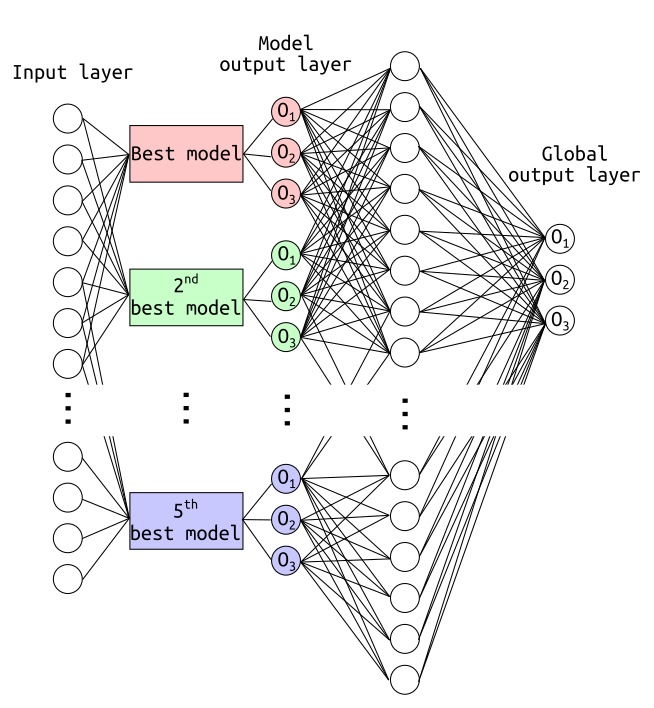

In [ ]:
the_input = keras.Input(shape=(32,32,3))

nn_legs = []
for i_key in best_5_nn_indices:
    output_i = test_nn[i_key](the_input)
    nn_legs.append(output_i)

x = Concatenate()(nn_legs)
x = Dense(1024,activation='relu')(x)
the_output = Dense(10,activation='softmax')(x)

merged_model = Model(inputs=the_input,outputs=the_output)
merged_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rlr = keras.callbacks.ReduceLROnPlateau(patience=15, verbose=1)
es = keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
merged_model.fit_generator(train_iterator, validation_data=test_iterator, epochs=50, callbacks=[rlr,es])

Great! We have improved it by almost 3 %!

Now let's use it to predict the test data! For doing that we are going to try a new tool. Instead of manually creating a numpy array and transform it into an iterator, we are going to use flow_from_directory, that will create the iterator directly for us. It will be quite handy, because now we have 300000 images. If we create a numpy array, it will be 10 times larger and we may have memory problems.

In [ ]:
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z', '/tmp/testfiles')

In [ ]:
! ls /tmp/testfiles/test | wc -l

In [ ]:
predict_preprocessing = ImageDataGenerator(rescale=1.0 / 255.0)
predict_iterator = predict_preprocessing.flow_from_directory(directory='/tmp/testfiles',target_size=(32,32),color_mode='rgb',class_mode=None,batch_size=256,shuffle=False)

prediccion = merged_model.predict_generator(predict_iterator)


The prediction array has now a numpy array shape. We have to invert the one hot encoder to get back which class the neural network is predicting

In [ ]:
label_prediction = onehot_encoder.inverse_transform(prediccion)

And finally we generate the prediction csv file in order to submit the results.

In [ ]:
prediction_df = pd.DataFrame(label_prediction)

# In order to get the indices right, we must take into account that flow_from_directory reads files on a alphabetical order. This means that after '1' comes '10' and not two.
# For that reason we need to play around a little bit with the indices, to sort them alphabetically.
labels_text_sorted = sorted([ str(x) for x in range(1, prediction_df.shape[0] + 1)])
labels_as_integers = [int(x) for x in labels_text_sorted]
prediction_df.insert(0,'Indice',labels_as_integers)
prediction_df = prediction_df.sort_values(by=['Indice'])

prediction_df.to_csv('/kaggle/working/prediction.csv',
                     header=['id','label'],index=False)